In [143]:
import cello
import os
import pandas as pd
import scanpy as sc
from anndata import AnnData
import csv
import numpy as np

In [144]:
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.0 scipy==1.7.3 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5


In [145]:
with open('data/cluster.csv', newline='', mode='r', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    data = list(reader)

flat_list = []
for sublist in data:
    for item in sublist:
        flat_list.append(item) 

In [147]:
with open('data/annotation.csv', newline='', mode='r', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    data = list(reader)

flat_list2 = []
for sublist in data:
    for item in sublist:
        flat_list2.append(item) 

In [148]:
df = pd.read_csv(
  "data/exp_matrix.csv",
  index_col=0
)
df = df.transpose()
adata = AnnData(df)

In [149]:
adata

AnnData object with n_obs × n_vars = 1561 × 48043

normalizing counts per cell
    finished (0:00:00)


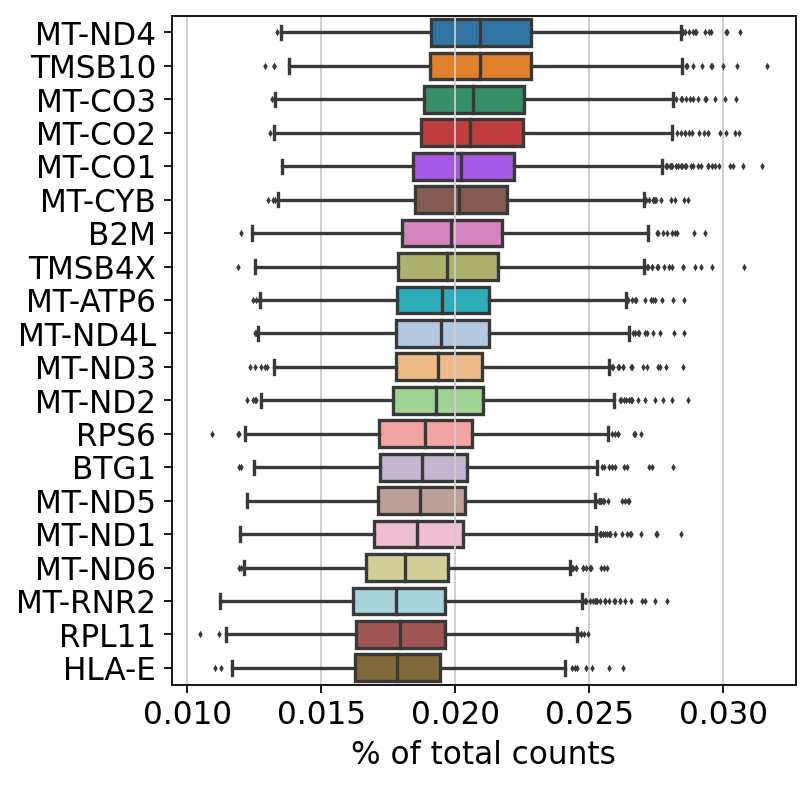

filtered out 3201 genes that are detected in less than 3 cells


In [150]:
sc.pl.highest_expr_genes(adata, n_top=20) #i 20 geni più espressi
sc.pp.filter_cells(adata, min_genes=200) #filtro le cellule che hanno meno di 200 geni espressi
sc.pp.filter_genes(adata, min_cells=3) #filtro i geni espressi in meno di 3 cellule
adata.var['mt']= adata.var_names.str.startswith('mt-') #annotazione dei gruppi di geni mitocondriali
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #calcolo la percentuale di geni mitocondriali

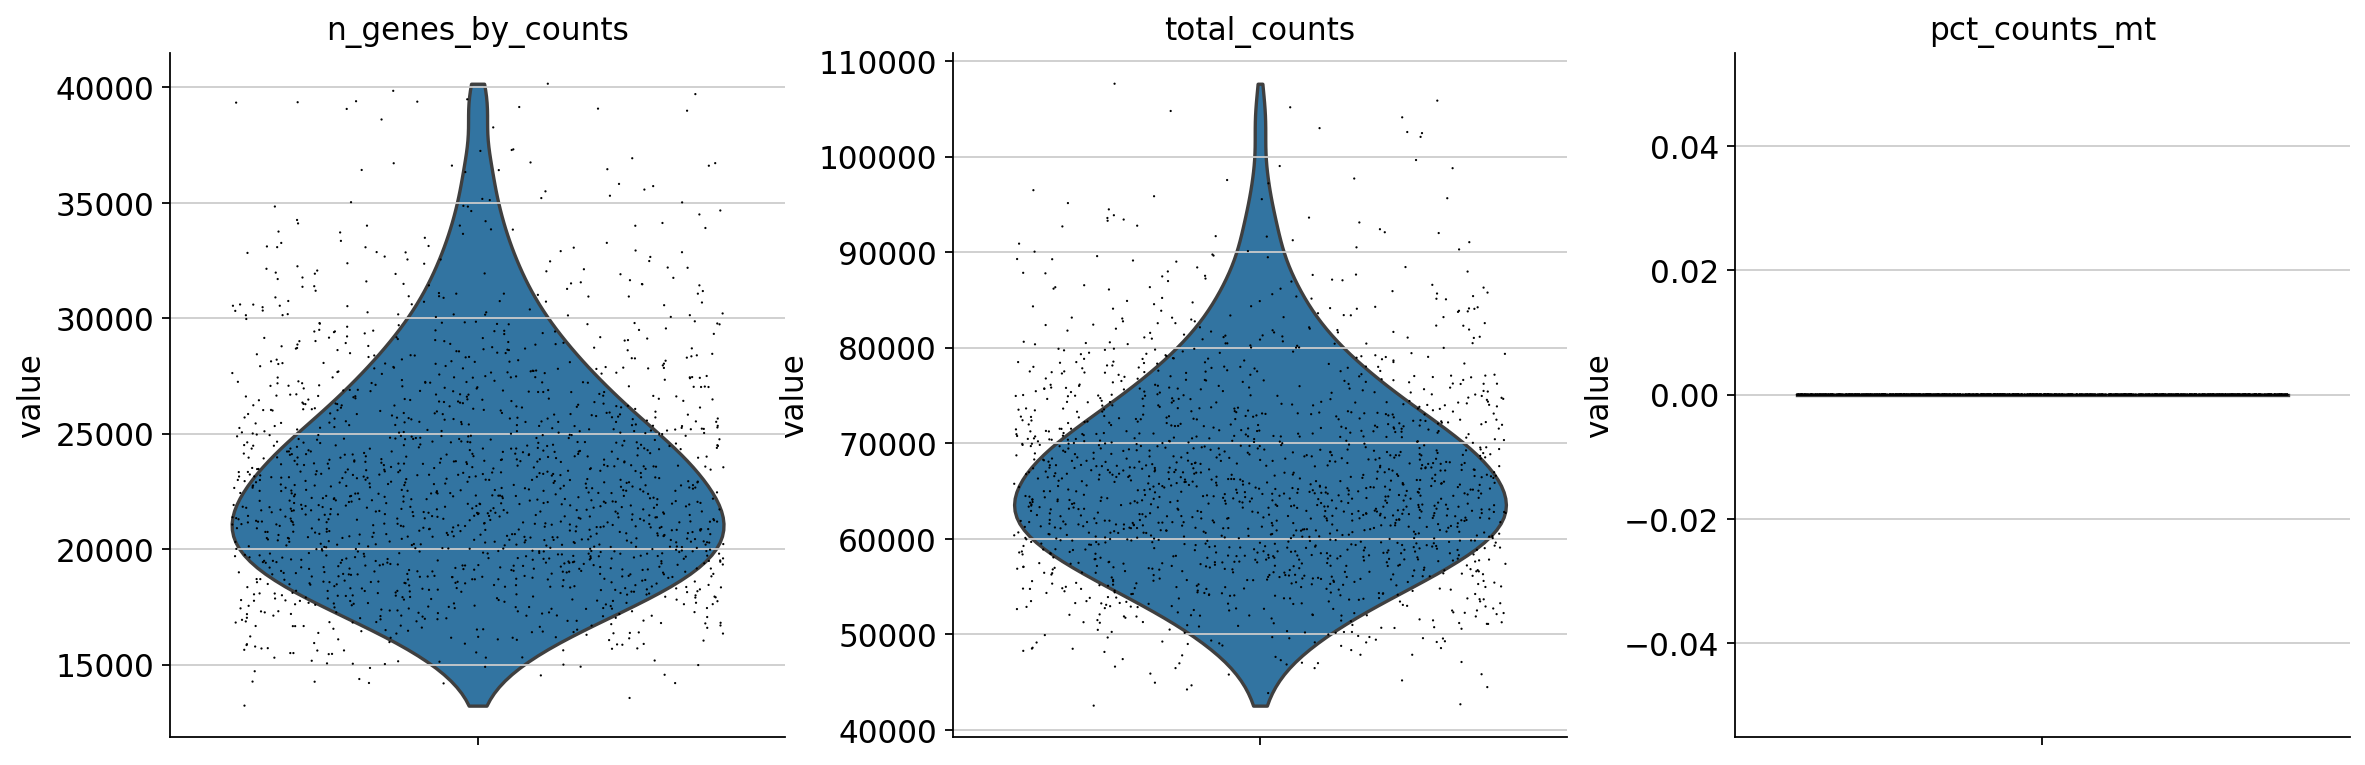

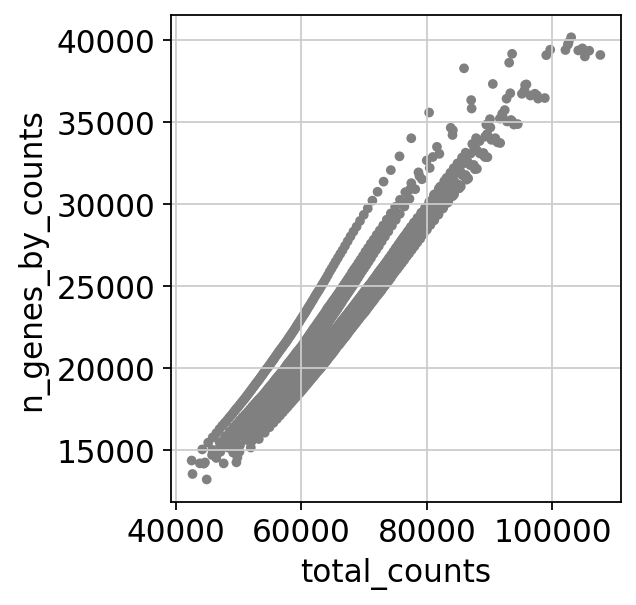

In [151]:
sc.pl.violin(adata, ['n_genes_by_counts','total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts',y='n_genes_by_counts')

In [152]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


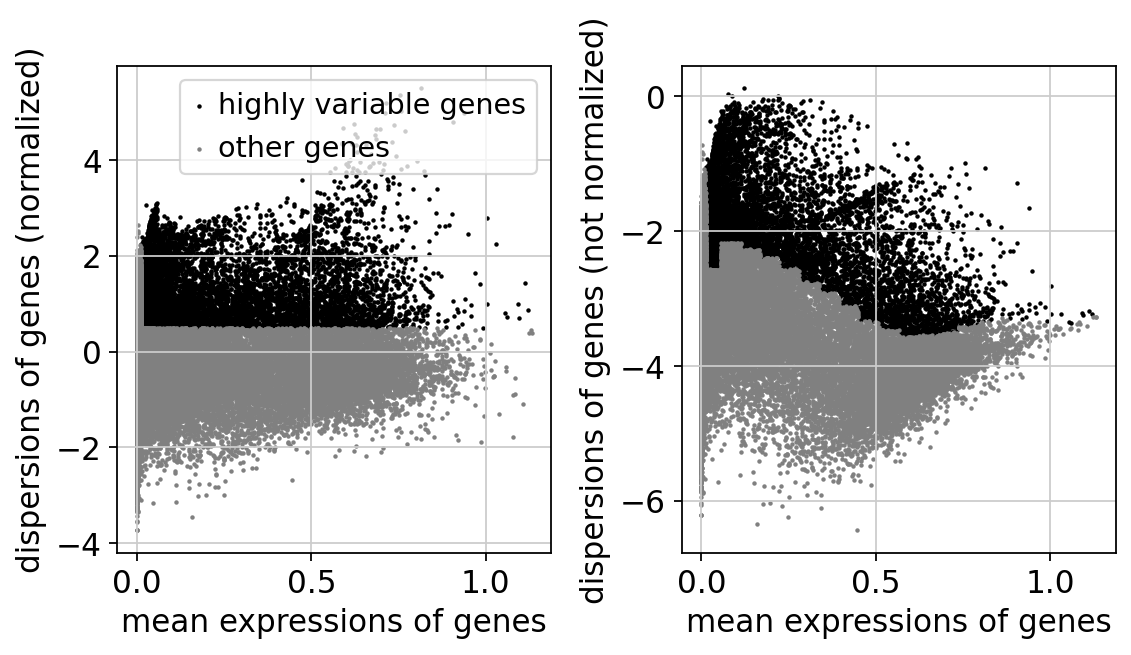

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


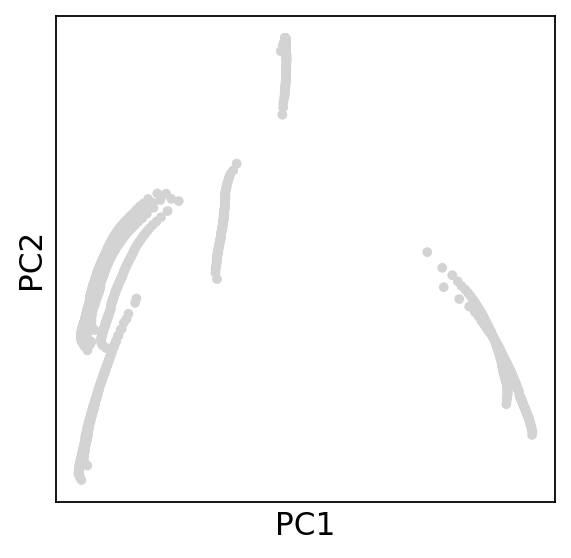

In [153]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 
sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

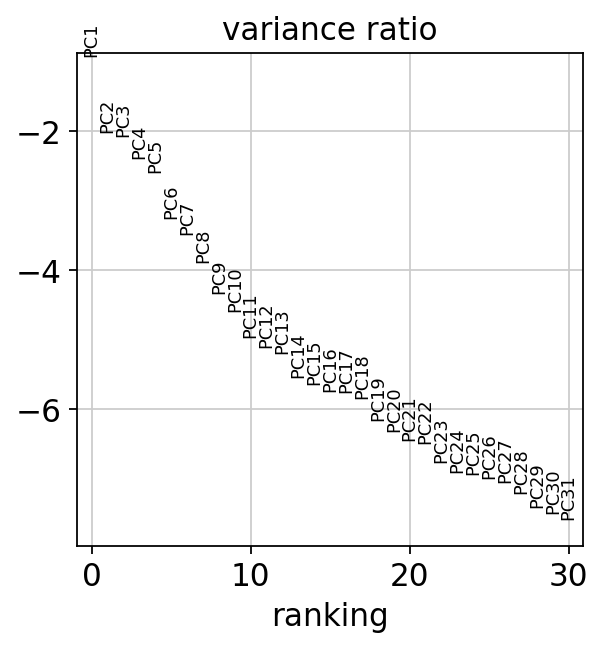

AnnData object with n_obs × n_vars = 1561 × 44842
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [154]:
sc.pl.pca_variance_ratio(adata, log=True)
adata

In [155]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15) #provo con 15
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [156]:
adata.obs['cluster'] = flat_list
adata.obs['actual_cluster'] = flat_list2

In [157]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [158]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


/home/chiara/anaconda3/envs/cello_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster' as categorical
/home/chiara/anaconda3/envs/cello_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'actual_cluster' as categorical


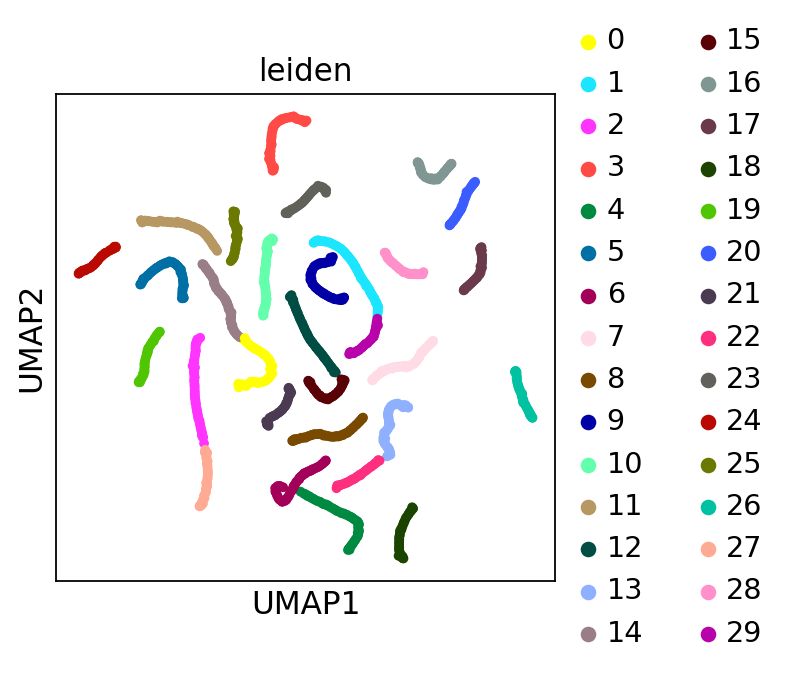

In [159]:
sc.pl.umap(adata, color='leiden')

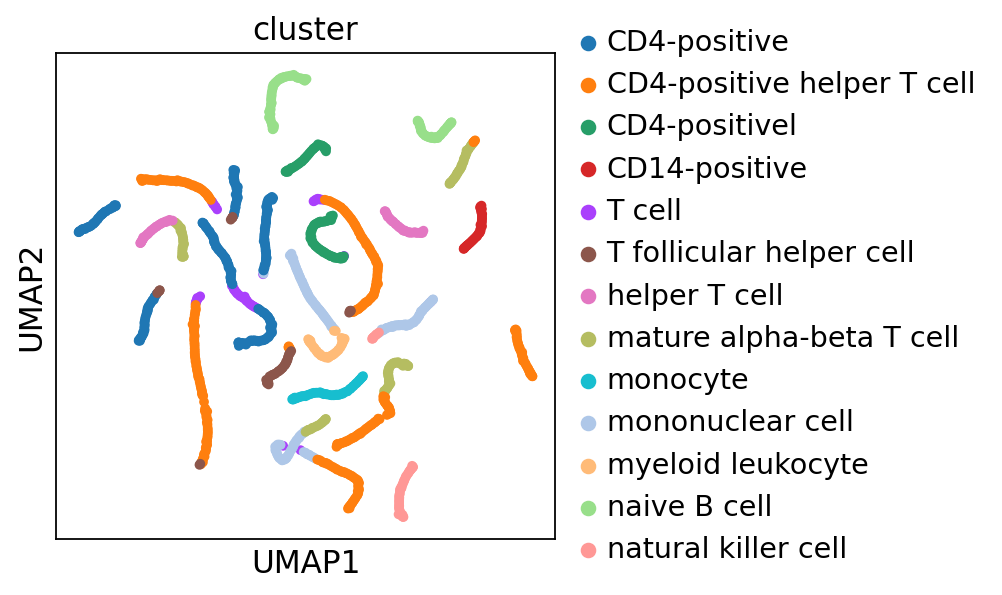

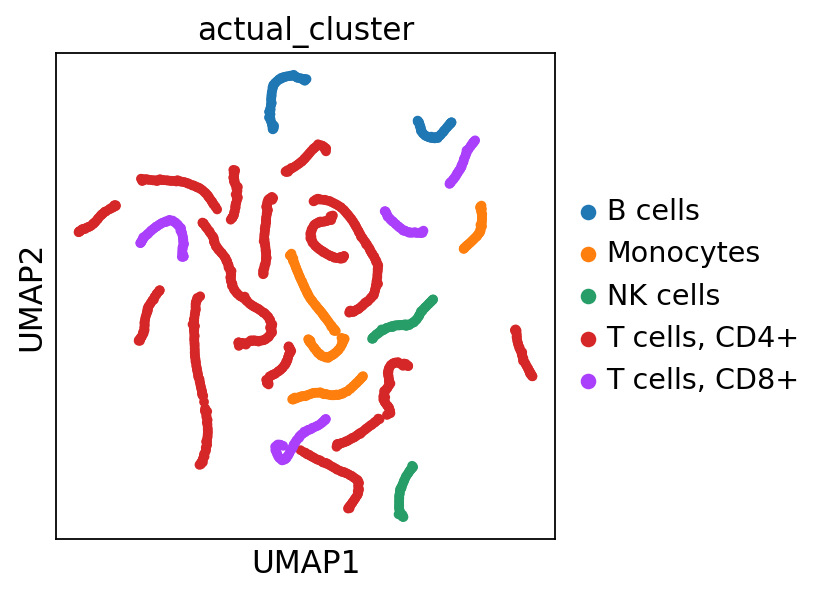

In [160]:
sc.pl.umap(adata, color='cluster')
sc.pl.umap(adata, color = 'actual_cluster')

In [161]:
def compare_cluster(comp1: str, comp2: str) -> bool:
    if comp1 == 'naive B cell':
        if comp2 == 'B cells':
            return True 
        else:
            return False
    elif comp1 == ['monocyte','CD14-positive']:
        if comp2 == 'Monocytes':
            return True 
        else:
            return False 
    elif comp1 == 'mononuclear cell':
        return False
    elif comp1 == 'myeloid leukocyte':
        return False
    elif comp1 == 'natural killer cell':
        if comp2 == 'NK cells':
            return True
        else:
            return False
    elif comp1 in ['CD4-positivel', 'CD4-positive helper T cell','T cell', 'mature alpha-beta T cell', 'CD4-positive','T follicular helper cell']:
        if comp2 in ['T cells, CD4+', 'T cells, CD8+']:
            return True
        else:
            return False

In [162]:
hit:'list[bool]' = []
for item in zip(adata.obs.cluster, adata.obs.actual_cluster) :  
    hit.append(compare_cluster(item[0],item[1]))

In [ ]:
dataset = { 'Cluster': adata.obs.cluster,
        'Actual Cluster': adata.obs.actual_cluster,
        'Hit': hit}
df_dataset = pd.DataFrame(dataset)

In [172]:
cluster_list = ['naive B cell','monocyte','CD14-positive','mononuclear cell','myeloid leukocyte',
        'natural killer cell','CD4-positivel', 'CD4-positive helper T cell','T cell', 'mature alpha-beta T cell', 'CD4-positive','T follicular helper cell','helper T cell']
true_list = ['B cells','Monocytes','NK cells','T cells, CD4+', 'T cells, CD8+']

confront = np.zeros((len(true_list), len(adata.obs.cluster)))
for index,item in enumerate(true_list):
    for index_p,item_conf in enumerate(adata.obs.cluster):
        if(compare_cluster(item_conf,item)):
            confront[index][index_p] += 1

In [173]:
cells = {label: {label2: 0 for label2 in cluster_list} for label in true_list}
for item in zip(adata.obs.actual_cluster,adata.obs.cluster):
  cells[item[0]][item[1]] += 1

{'B cells': {'naive B cell': 106,
  'monocyte': 0,
  'CD14-positive': 0,
  'mononuclear cell': 0,
  'myeloid leukocyte': 0,
  'natural killer cell': 0,
  'CD4-positivel': 0,
  'CD4-positive helper T cell': 0,
  'T cell': 0,
  'mature alpha-beta T cell': 0,
  'CD4-positive': 0,
  'T follicular helper cell': 0,
  'helper T cell': 0},
 'Monocytes': {'naive B cell': 0,
  'monocyte': 62,
  'CD14-positive': 44,
  'mononuclear cell': 59,
  'myeloid leukocyte': 46,
  'natural killer cell': 0,
  'CD4-positivel': 0,
  'CD4-positive helper T cell': 0,
  'T cell': 0,
  'mature alpha-beta T cell': 0,
  'CD4-positive': 0,
  'T follicular helper cell': 0,
  'helper T cell': 0},
 'NK cells': {'naive B cell': 0,
  'monocyte': 0,
  'CD14-positive': 0,
  'mononuclear cell': 51,
  'myeloid leukocyte': 0,
  'natural killer cell': 53,
  'CD4-positivel': 0,
  'CD4-positive helper T cell': 0,
  'T cell': 1,
  'mature alpha-beta T cell': 0,
  'CD4-positive': 0,
  'T follicular helper cell': 0,
  'helper T cell

<AxesSubplot:>

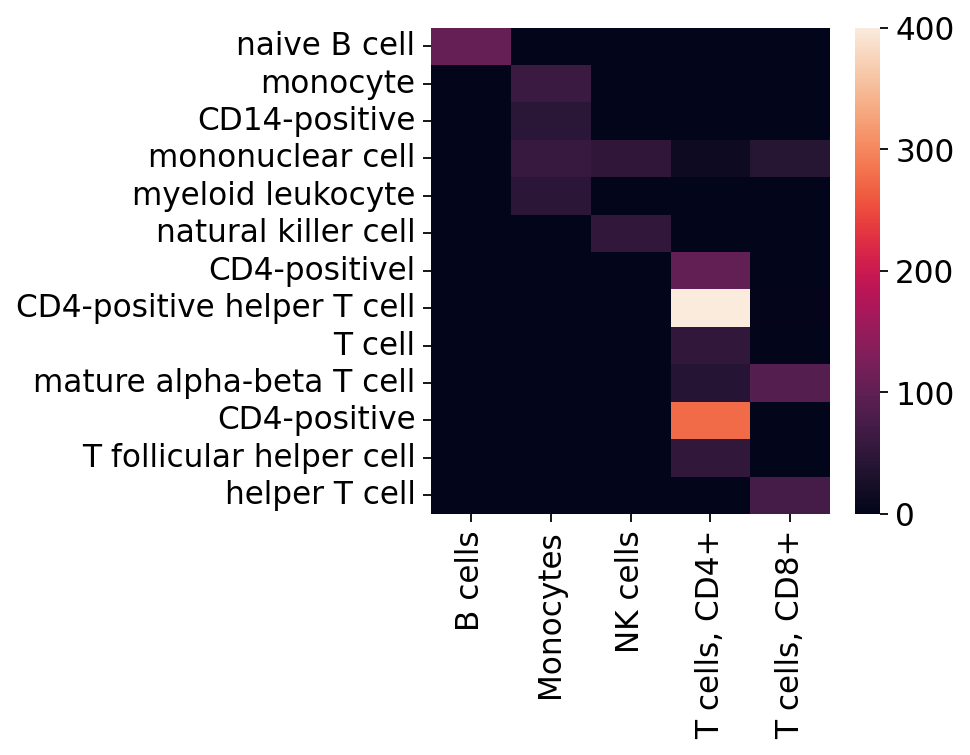

In [178]:
import seaborn as sns
df_cells = pd.DataFrame.from_dict(cells)
sns.heatmap(df_cells)

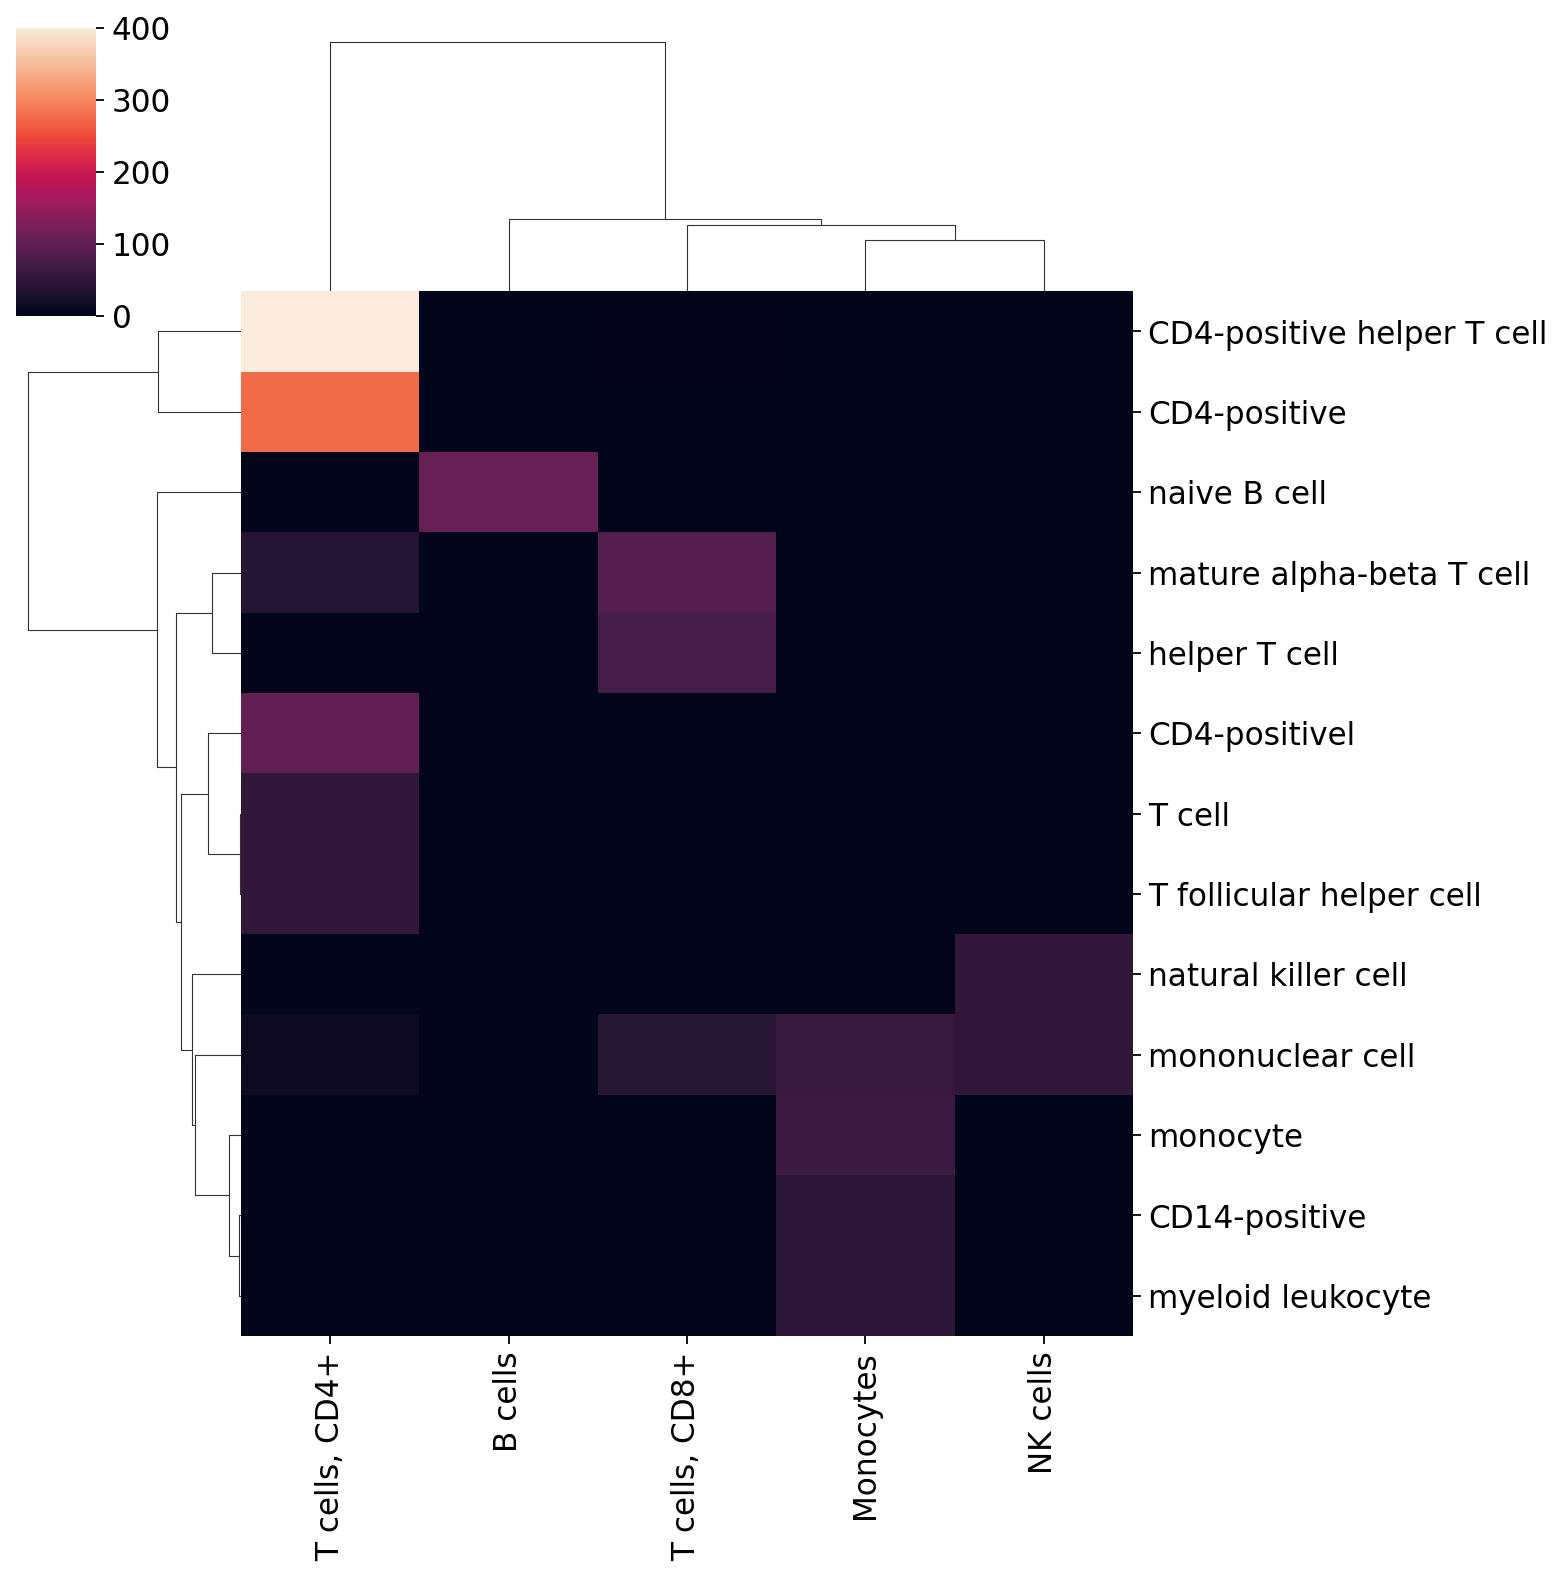

In [179]:
sns.clustermap(cells)

In [211]:
import collections
counter=collections.Counter(adata.obs.actual_cluster)
norm_cells = {label: {label2: 0 for label2 in cluster_list} for label in true_list}
for (inner_key, inner_value) in cells.items():
  for (key,value) in inner_value.items():
    norm_cells[inner_key][key] = (counter[inner_key] - value)/1561

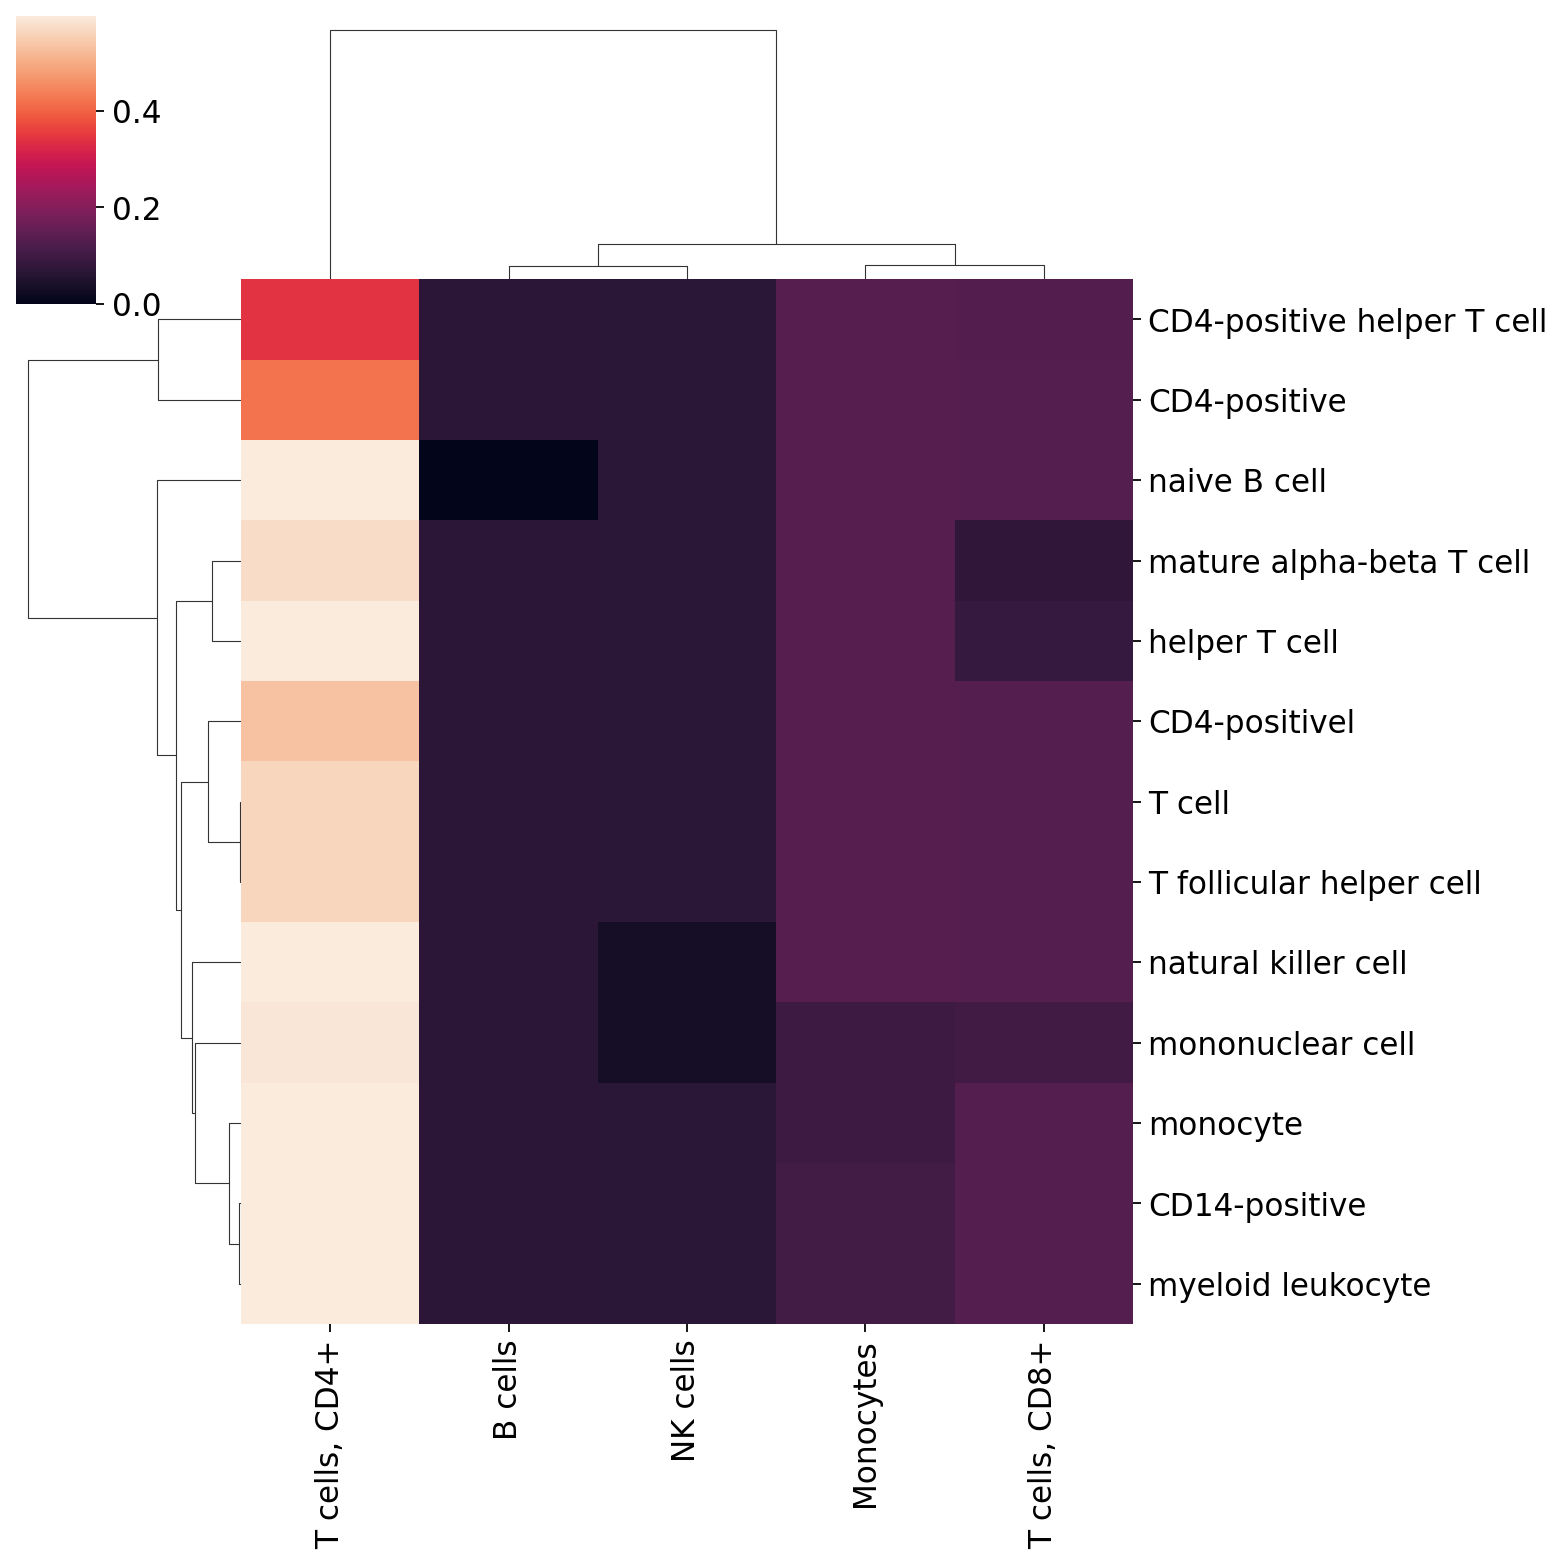

In [212]:
sns.clustermap(norm_cells)

In [210]:
sum(counter.values())

1561